In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

import findatree.io as io
import findatree.visualize as visual
import findatree.segmentation as segment
import findatree.object_properties as obj_props

plt.style.use(r"C:\Repos\findatree\own.mplstyle")

### Define paths to rasters

In [2]:
importlib.reload(io)
dir_names=[]
dir_names.extend([r'C:\Data\lwf\DSM_2021'])
dir_names.extend([r'C:\Data\lwf\DTM'])
dir_names.extend([r'C:\Data\lwf\Orthophotos_2021'])

file_names=[]
# file_names.extend(['Tnr_12702_D-20210713_DSM.tif'])
# file_names.extend(['tnr_12702_dtm.tif'])
# file_names.extend(['Tnr_12702_2021_Ortho.tif'])

# file_names.extend(['Tnr_11044_D-20210707_DSM.tif'])
# file_names.extend(['tnr_11044_dtm.tif'])
# file_names.extend(['Tnr_11044_2021_Ortho.tif'])

# file_names.extend(['Tnr_11626_D-20210719_DSM.tif'])
# file_names.extend(['tnr_11626_dtm.tif'])
# file_names.extend(['Tnr_11626_2021_Ortho.tif'])

file_names.extend(['Tnr_11090_D-20210719_DSM.tif'])
file_names.extend(['tnr_11090_dtm.tif'])
file_names.extend(['Tnr_11090_2021_Ortho.tif'])

paths=[os.path.join(dir_names[i],file_name) for i, file_name in enumerate(file_names)]

# io.print_raster_info(paths)

### Reproject all rasters to same area & resolution

In [3]:
importlib.reload(io)

# Set final resolution of all rasters
resolution = 0.2

# Reproject all rasters
bands, mask, A, bound = io.reproject_all_intersect(paths, resolution=resolution)

C:\Users\flori\Anaconda3\envs\findatree_v01\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


### Define primary and (normalized) secondary channels
- blue: 450 nm ± 16 nm
- green: 560 nm ± 16 nm
- red: 650 nm ± 16 nm
- red edge (re): 730 nm ± 16 nm
- near infrared (nir): 840 nm ± 26 nm

In [76]:
importlib.reload(io)

# Primary raster channels 
cs_prim = {
    'dsm': bands[0][:,:,0],
    'dtm': bands[1][:,:,0],
    'blue': bands[2][:,:,0],
    'green': bands[2][:,:,1],
    'red': bands[2][:,:,2],
    're': bands[2][:,:,3],
    'nir': bands[2][:,:,4],
}

# Secondary raster channels
downscale = 0
cs, shape_in, shape_out = io.define_channels(cs_prim, downscale=downscale)

px_width = resolution * 2**downscale
print(f"Primary channel names: {[k for k in cs_prim]}")
print(f"Secondary channel names: {[k for k in cs]}")
print(f"Pixel width: {px_width:.1f} [m]")
print(f"Image shape: {shape_out} [px]")

Primary channel names: ['dsm', 'dtm', 'blue', 'green', 'red', 're', 'nir']
Secondary channel names: ['blue', 'green', 'red', 're', 'nir', 'chm', 'ndvi', 'ndvire', 'ndre', 'RGB', 'rgb', 'h', 'l', 's']
Pixel width: 0.2 [m]
Image shape: (2010, 1886) [px]


### Segmentation -> Objects
#### (1) Segmentation
1. Local gaussian thresholding -> mask
2. Marker based watershed with markers generated by local peaks in distance transformation of mask

In [77]:
importlib.reload(segment)

thresh_dict={
    'downscale': 1,
    'width':30,
    'blur':False,
}
water_dict={
    'downscale': 0,
    'peak_dist': 1.2,
}

labels, bounds, mask_seed, mask_global, thresh_dict, water_dict = segment.main(
    cs_prim,
    resolution,
    thresh_dict,
    water_dict,
)

Thresholding params.:
{'downscale': 1, 'width': 30, 'blur': False, 'channel': 'l', 'shape': (1005, 943), 'px_width': 0.4}
Watershed params.:
{'downscale': 0, 'peak_dist': 1.2, 'channel': 'l', 'shape': (2010, 1886), 'px_width': 0.2}

    ... (thresholding) Gaussian thresholding kernel width: 30.0 [m] = 75 [px]
    ... (watershed) Removing holes of area: 0.00 [m**2] = 0 [px]
    ... (watershed) Peaks in distance transform separated by minimum distance: 1.2 [m] = 5 [px]


#### (2) Plot segmentation results

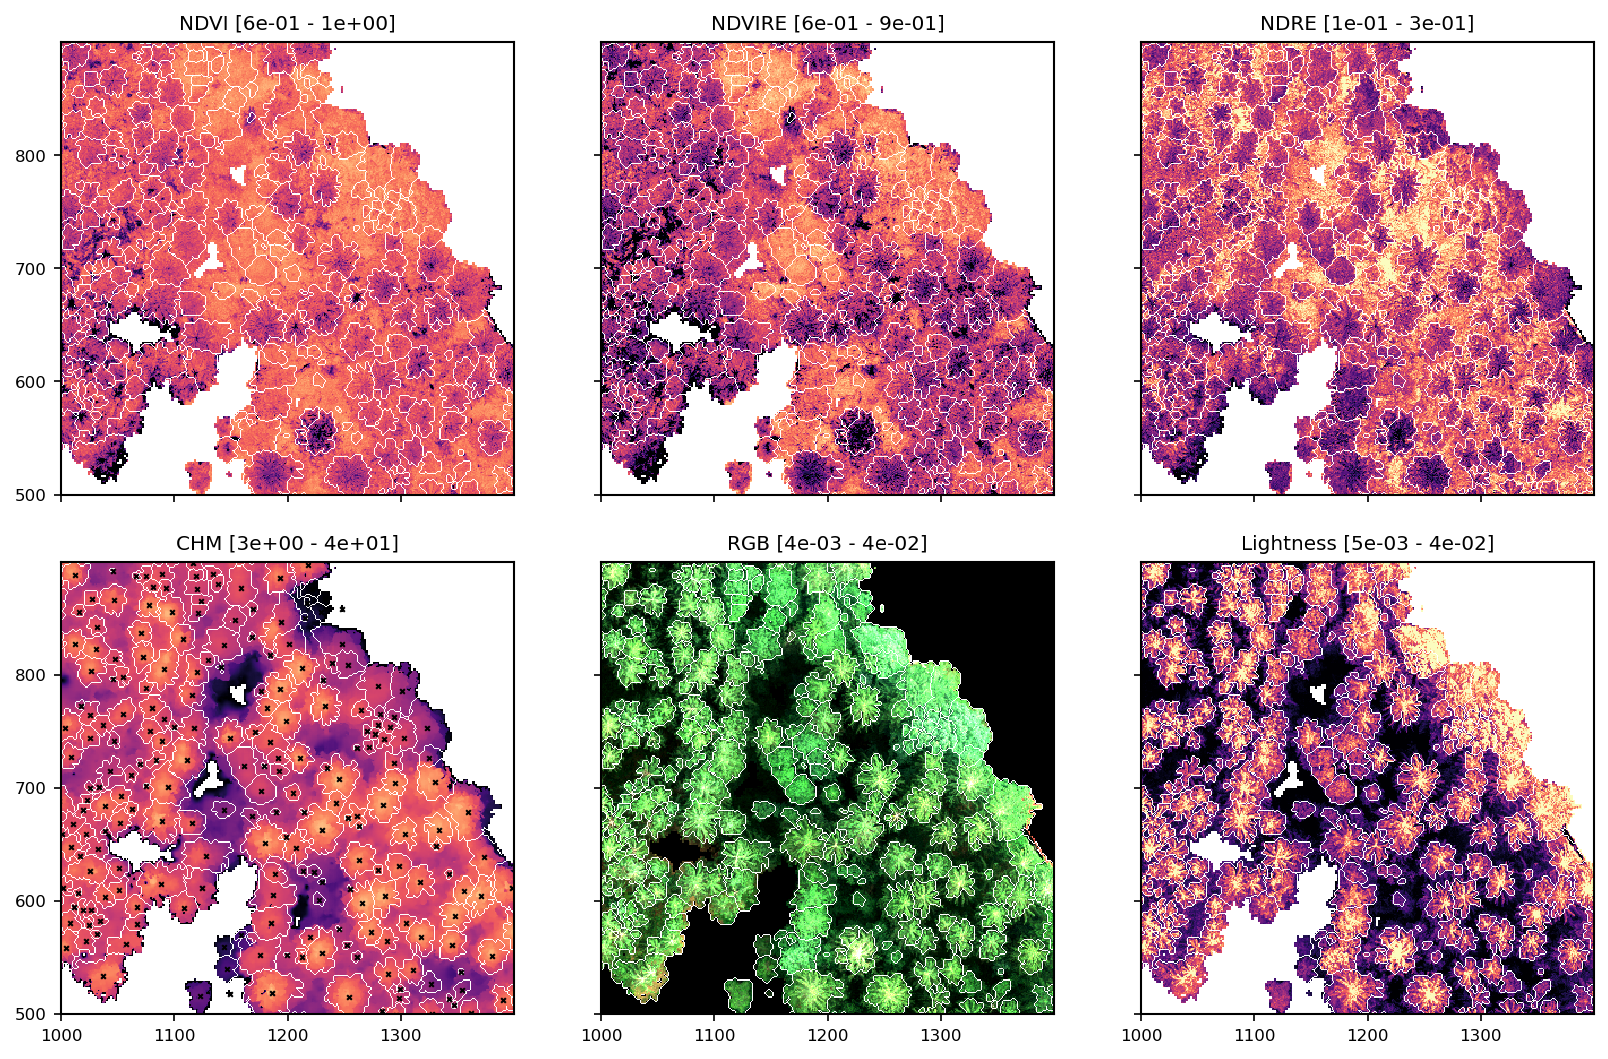

In [180]:
importlib.reload(visual)

channels = [
    cs['ndvi'], cs['ndvire'], cs['ndre'], 
    cs['chm'], cs['RGB'], cs['l'],
]
channels_names = [
    'NDVI', 'NDVIRE','NDRE',  
    'CHM', 'RGB', 'Lightness',
]
contrasts = [
    (0.6, 1), (0.6,0.9), (0.15,0.35), 
    (3, 40), None, None,
]

# ROI
width = 200
x_center = 1200
y_center = 700
xylim = [(x_center, width), (y_center, width)]

f, axs = visual.show_channels(
    channels,
    xylim=xylim,
    mask=mask_global,
    bounds=bounds,
    contrasts=contrasts,
    channel_names=channels_names,
    zoom=1.2,
    n_cols_rows=(3,2),
)

ax = axs[3]
idx = names.index('x_com_chm')
x = props[:, idx] - (x_center - width)
idx = names.index('y_com_chm')
y = props[:, idx] - (y_center - width)
ax.scatter(
    x,
    y,
    s=5,
    marker='x',
    ec='k',
)

for ax in axs:
    ax.set_xlim(0, 2 * width)
    ax.set_ylim(0, 2 * width)

### Object properties
#### (1) Extract object properties

In [164]:
importlib.reload(obj_props)
props, names = obj_props.labels_to_props_all(labels, cs, px_width, include_labels=None)

100%|██████████| 3127/3127 [01:48<00:00, 28.88it/s]


['label', 'area', 'area_convex', 'area_filled', 'axis_major_length', 'axis_minor_length', 'equivalent_diameter_area', 'perimeter', 'perimeter_crofton', 'feret_diameter_max', 'eccentricity', 'extent', 'solidity', 'n_px_bright', 'min_blue', 'max_blue', 'mean_blue', 'std_blue', 'median_blue', 'perc25_blue', 'perc75_blue', 'mean_lowerl_blue', 'mean_upperl_blue', 'x_max_blue', 'y_max_blue', 'x_com_blue', 'y_com_blue', 'min_green', 'max_green', 'mean_green', 'std_green', 'median_green', 'perc25_green', 'perc75_green', 'mean_lowerl_green', 'mean_upperl_green', 'x_max_green', 'y_max_green', 'x_com_green', 'y_com_green', 'min_red', 'max_red', 'mean_red', 'std_red', 'median_red', 'perc25_red', 'perc75_red', 'mean_lowerl_red', 'mean_upperl_red', 'x_max_red', 'y_max_red', 'x_com_red', 'y_com_red', 'min_re', 'max_re', 'mean_re', 'std_re', 'median_re', 'perc25_re', 'perc75_re', 'mean_lowerl_re', 'mean_upperl_re', 'x_max_re', 'y_max_re', 'x_com_re', 'y_com_re', 'min_nir', 'max_nir', 'mean_nir', 'std_

(0.0, 1.0)

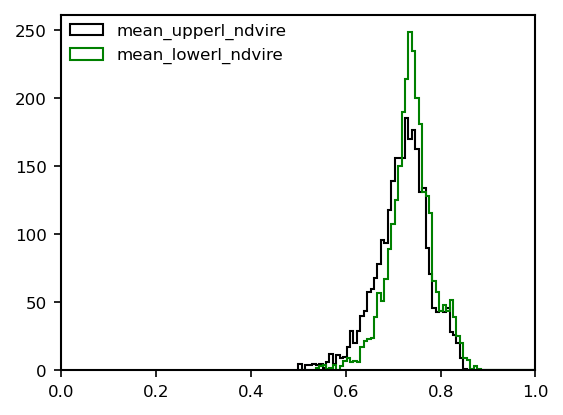

In [207]:
print(names)

xlim = [0., 1]

# Filter
name = 'n_px_bright'
positives = props[:, names.index(name)]
positives = positives > 10

select = [
    # 'median_ndvire',
    'mean_upperl_ndvire',
    'mean_lowerl_ndvire',
    # 'std_ndvire',
    # 'perc25_ndvire',
    # 'perc75_ndvire',
    # 'max_ndvire',
    ]

bins = np.linspace(0.5,1,70)
# bins=100


f, ax = plt.subplots(figsize=[4,3])

for name in select:
    idx = names.index(name)
    feature = props[:, idx]

    _ = ax.hist(
        feature[positives],
        bins=bins,
        histtype='step',
        label=name,
        )

_ = ax.legend(loc='upper left')
ax.set_xlim(xlim)

['label', 'area', 'area_convex', 'area_filled', 'axis_major_length', 'axis_minor_length', 'equivalent_diameter_area', 'perimeter', 'perimeter_crofton', 'feret_diameter_max', 'eccentricity', 'extent', 'solidity', 'n_px_bright', 'min_blue', 'max_blue', 'mean_blue', 'mean_lower_blue', 'mean_upper_blue', 'x_max_blue', 'y_max_blue', 'min_green', 'max_green', 'mean_green', 'mean_lower_green', 'mean_upper_green', 'x_max_green', 'y_max_green', 'min_red', 'max_red', 'mean_red', 'mean_lower_red', 'mean_upper_red', 'x_max_red', 'y_max_red', 'min_re', 'max_re', 'mean_re', 'mean_lower_re', 'mean_upper_re', 'x_max_re', 'y_max_re', 'min_nir', 'max_nir', 'mean_nir', 'mean_lower_nir', 'mean_upper_nir', 'x_max_nir', 'y_max_nir', 'min_chm', 'max_chm', 'mean_chm', 'mean_lower_chm', 'mean_upper_chm', 'x_max_chm', 'y_max_chm', 'min_ndvi', 'max_ndvi', 'mean_ndvi', 'mean_lower_ndvi', 'mean_upper_ndvi', 'x_max_ndvi', 'y_max_ndvi', 'min_ndvire', 'max_ndvire', 'mean_ndvire', 'mean_lower_ndvire', 'mean_upper_ndvi

Text(0, 0.5, 'max_ndre')

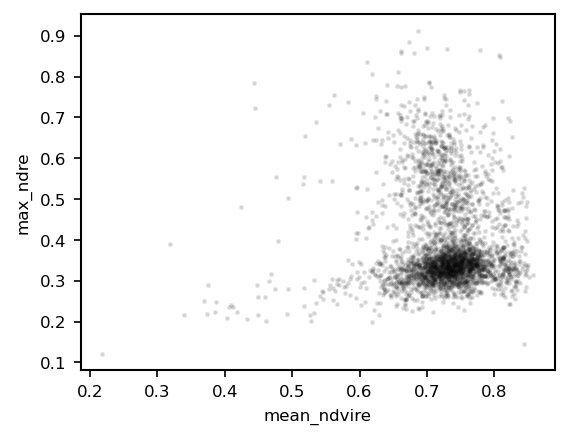

In [163]:
print(names)
f, ax = plt.subplots(figsize=[4,3])

name1 = 'mean_ndvire'
idx1 = names.index(name1)
feature1 = props[:, idx1]

name2 = 'max_ndre'
idx2 = names.index(name2)
feature2 = props[:, idx2]

name3 = 'max_ndvire'
idx3 = names.index(name3)
feature3 = props[:, idx3]

x = feature1
y = feature2
z = feature3

_ = ax.scatter(
    x,
    y,
    # c=z,
    s=2,
    alpha=0.1,
    )

ax.set_xlabel(name1)
ax.set_ylabel(name2)
# ax.set_xlim(0.6,1)
# ax.set_ylim(0.5,1)